# Basic imputation

The original data source can be found [here](https://archive.ics.uci.edu/dataset/222/bank+marketing).

I've modified the data for the course and uploaded it to the repo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer,
)

In [2]:
data = pd.read_csv("../bank-marketing.csv")

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0,unknown,0
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0,unknown,0
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,NaN,-1.0,0,unknown,0
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0,unknown,0
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0,unknown,0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("subscribe", axis=1),
    data["subscribe"],
    test_size=0.33,
    random_state=42,
)

# Which categorical variables have na?

In [4]:
vars_na = [c for c in X_train.columns if X_train[c].isnull().any()]

data[vars_na].isnull().mean()

job         0.010219
balance     0.083519
contact     0.102763
day         0.018137
duration    0.087943
campaign    0.207450
pdays       0.162195
poutcome    0.037225
dtype: float64

In [5]:
# categorical variables with nan

cat_vars_na = [c for c in vars_na if X_train[c].dtypes=="O"]
cat_vars_na

['job', 'contact', 'poutcome']

In [6]:
X_train[vars_na].head()

,job,balance,contact,day,duration,campaign,pdays,poutcome
41031,housemaid,NaN,cellular,13.0,126.0,2.0,-1.0,NaN
41950,NaN,0.0,cellular,22.0,102.0,NaN,NaN,failure
39883,services,935.0,NaN,2.0,136.0,1.0,96.0,failure
44938,housemaid,3232.0,NaN,6.0,541.0,1.0,204.0,failure
42103,technician,508.0,cellular,2.0,154.0,3.0,-1.0,unknown


Job, contact and poutcome.

# Which numerical variables have na?

In [7]:
num_vars_na = [c for c in vars_na if X_train[c].dtypes!="O"]
num_vars_na

['balance', 'day', 'duration', 'campaign', 'pdays']

balance, day, duration, campaign and pdays.

# Would you use mean or median imputation?

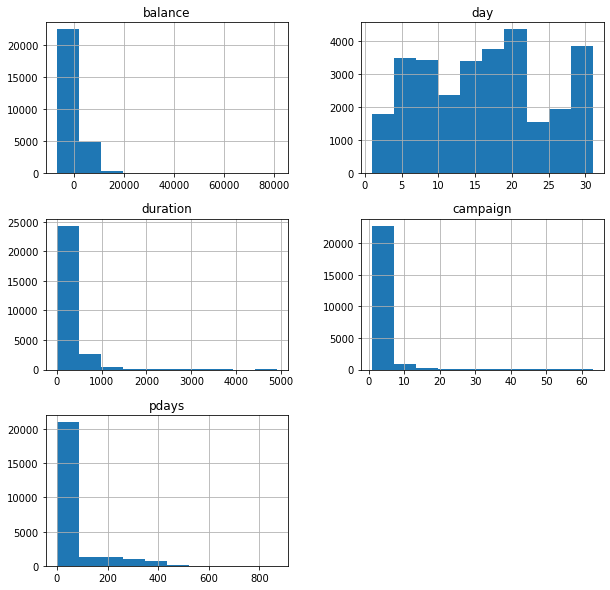

In [8]:
X_train[num_vars_na].hist(figsize=(10,10))
plt.show()

For most variables, I'd use the median as they are skewed. The variable "day" is uniform, so in principle, we could use either.

# Impute with the median using Feature-engine

In [19]:
imputer = MeanMedianImputer(imputation_method="mean")

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [20]:
imputer.imputer_dict_

{'age': 40.9446700340035,
 'balance': 1352.815571407984,
 'day': 15.814869588599086,
 'duration': 256.709221140976,
 'campaign': 2.766763969974979,
 'pdays': 40.437788746298125,
 'previous': 0.5761777425637978}

# Impute with an arbitrary string using Feature-engine

In [11]:
imputer = CategoricalImputer()

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil

In [12]:
imputer.imputer_dict_

{'job': 'Missing',
 'marital': 'Missing',
 'education': 'Missing',
 'default': 'Missing',
 'housing': 'Missing',
 'loan': 'Missing',
 'contact': 'Missing',
 'month': 'Missing',
 'poutcome': 'Missing'}

In [13]:
# check absence of nan

[c for c in X_test.columns if X_test[c].isnull().any()]

[]

Subscribe is binary, and day is discrete. I'd argue that we can consider the rest of the variables continuous.

# Impute using sklearn

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("subscribe", axis=1),
    data["subscribe"],
    test_size=0.33,
    random_state=42,
)

In [15]:
imputer = ColumnTransformer(
    [
        ("num_imputer", SimpleImputer(strategy="median"), num_vars_na),
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing"), cat_vars_na),
    ],
    remainder="passthrough",
).set_output(transform="pandas")

In [16]:
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train.head()

,num_imputer__balance,num_imputer__day,num_imputer__duration,num_imputer__campaign,num_imputer__pdays,cat_imputer__job,cat_imputer__contact,cat_imputer__poutcome,remainder__age,remainder__marital,remainder__education,remainder__default,remainder__housing,remainder__loan,remainder__month,remainder__previous
41031,448.0,13.0,126.0,2.0,-1.0,housemaid,cellular,missing,29,single,tertiary,no,no,no,aug,0
41950,0.0,22.0,102.0,2.0,-1.0,missing,cellular,failure,55,married,secondary,no,no,no,oct,1
39883,935.0,2.0,136.0,1.0,96.0,services,missing,failure,56,divorced,secondary,no,no,no,jun,3
44938,3232.0,6.0,541.0,1.0,204.0,housemaid,missing,failure,47,single,tertiary,no,no,no,oct,3
42103,508.0,2.0,154.0,3.0,-1.0,technician,cellular,unknown,39,married,tertiary,no,no,no,nov,0


In [17]:
# check absence of nan

[c for c in X_test.columns if X_test[c].isnull().any()]

[]